In [140]:
# !pip install dash
from dash import Dash, dcc, html, Input, Output
import networkx as nx
import pandas as pd
import random
import numpy as np
import plotly.graph_objs as go
from matplotlib.colors import to_hex, to_rgb

class StatTreeGenerator:
    def __init__(self, branch_pattern, performance_percentage=0.20, stopping_likelihood=0.5):
        """Initialize the StatTreeGenerator with branching patterns, base stats, max stat cap, 
        performance percentage, and stopping likelihood for high-performing nodes."""
        
        self.branch_pattern = branch_pattern
        self.performance_percentage = performance_percentage  # Metric n: Threshold as a percentage above the average stats
        self.stopping_likelihood = stopping_likelihood  # Likelihood x of stopping for high-performing nodes
        self.nodes = {}
        self.G = nx.DiGraph()
        self.base_stat = 50
        self.max_stat_cap = 250
        self.stats_names = ["Health", "PAttack", "PDefense", "MAttack", "MDefense", "Speed"]
        self.sibling_variation_factor = 0.1

        # Initialize with base stats for root node
        self.nodes["0"] = {
            "generation": 0,
            "stats": {stat: self.base_stat for stat in self.stats_names},
            "color": 'white'
        }
        
        # Color codes for Generation 1 nodes
        self.colors = {
            "0-0": 'magenta',
            "0-1": 'green',
            "0-2": 'yellow',
            "0-3": 'cyan',
            "0-4": 'black',
            "0-5": 'purple'
        }
        self.max_stats_per_generation = {}

    def get_generation_stat_threshold(self, generation):
        """Calculate the average total stats for nodes in a generation and add the performance percentage.
        
        Args:
            generation (int): The generation level for which to calculate the threshold.
        
        Returns:
            float: The stat threshold for this generation."""
        
        total_stats = [
            sum(node_data["stats"].values())
            for node_data in self.nodes.values()
            if node_data["generation"] == generation
        ]
        
        if total_stats:
            average_total = sum(total_stats) / len(total_stats)
            return average_total * (1 + self.performance_percentage)
        return float('inf')  # No threshold if no nodes are found
    
    def should_stop_high_performer(self, node_stats, generation):
        """Determine if a high-performing node should stop its lineage based on the stopping likelihood.
        
        Args:
            node_stats (dict): The stats of the node.
            generation (int): The generation of the node.
        
        Returns:
            bool: True if the node should stop its lineage, False otherwise."""
        
        total_stats = sum(node_stats.values())
        threshold = self.get_generation_stat_threshold(generation)
        
        # Check if the node exceeds the threshold and apply the likelihood
        if total_stats > threshold:
            return random.random() < self.stopping_likelihood
        return False

    def create_branches(self, parent_id, generation):
        """Recursively create child nodes for each generation, stopping high-performing lineages probabilistically.
        
        Args:
            parent_id (str): The ID of the parent node.
            generation (int): The generation level for the child nodes."""
        
        if generation > len(self.branch_pattern):
            return
        
        num_children = self.branch_pattern[generation - 1]
        
        for i in range(num_children):
            child_id = f"{parent_id}-{i}"
            
            if generation > 1:
                # Check if the parent node is a high performer and if it should stop lineage
                if self.should_stop_high_performer(self.nodes[parent_id]["stats"], generation - 1):
                    continue  # Skip creating this branch

            # Generation 1 uses predefined color codes
            if generation == 1:
                color = self.colors.get(child_id, 'gray')
                stats = self.generate_ranked_stats(generation)
            else:
                # For subsequent generations, adjust color and specialize stats
                color = self.adjust_color(self.nodes[parent_id]["color"], generation)
                stats = self.specialize_ranked_stats(parent_id, generation)

            # Add the child node and recursively create its branches
            self.nodes[child_id] = {"generation": generation, "stats": stats, "color": color}
            self.G.add_edge(parent_id, child_id)
            self.create_branches(child_id, generation + 1)
            
    def generate_tree(self):
        """Generate the entire tree structure starting from the root node, creating branches and calculating max stats for each generation."""
      
        node_id = "0"
        # Generation 0: initialize root node with base stats totaling 100
        base_stat = 100 // 6
        self.nodes[node_id] = {
            "generation": 0,
            "stats": {stat: base_stat for stat in ["Health", "PAttack", "PDefense", "MAttack", "MDefense", "Speed"]},
            "color": 'white'
        }
        self.G.add_node(node_id)
        self.create_branches(node_id, 1)
        
        # Calculate max stats for each generation
        self.calculate_max_stats_per_generation()

        # Convert nodes dictionary to DataFrame, separating 'stats' dictionary into individual columns
        data = []
        for node, node_data in self.nodes.items():
            row = {
                "node_id": node,
                "generation": node_data["generation"],
                "color": node_data["color"],
                **node_data["stats"]  # Unpack stats into individual columns
            }
            data.append(row)
            
        return pd.DataFrame(data)

    def calculate_max_stats_per_generation(self):
        """Calculate the maximum possible stats for each generation based on a weighted Fibonacci distribution.
        
        This function uses a doubling point system to determine max possible stat increases for each generation."""
      
        fibonacci_weights = [333, 222, 111, 55, 20, 3]
        total_weight = sum(fibonacci_weights)
        
        for generation in range(1, max(self.branch_pattern) + 1):
            min_points = 10 * (2 ** (generation - 1))
            max_points = 64 * (2 ** (generation - 1))
            max_additional_points = max_points
            
            # Calculate the maximum possible distribution for this generation
            stat_increase = [int(max_additional_points * weight / total_weight) for weight in fibonacci_weights]
            max_stat_increase = sum(stat_increase)
            self.max_stats_per_generation[generation] = max_stat_increase + 100  # Starting base stats + max increment

    def generate_ranked_stats(self, generation):
        """Generate stats for nodes in Generation 1 with variation based on stat distribution profiles: 
        'balanced', 'extreme_one', and 'extreme_two'.
        
        Args:
            generation (int): The generation level for which stats are being generated.
        
        Returns:
            dict: A dictionary of stats for the node."""
       
        base_points = 60 + 20 * generation
        stat_profile = random.choice(['balanced', 'extreme_one', 'extreme_two'])
        
        if stat_profile == 'balanced':
            base_allocation = base_points // len(self.stats_names)
            stats = {
                stat: min(max(self.base_stat, base_allocation + int(np.random.normal(0, base_allocation * 0.3))), self.max_stat_cap)
                for stat in self.stats_names
            }
        
        elif stat_profile == 'extreme_one':
            dominant_stat = random.choice(self.stats_names)
            stats = {stat: self.base_stat for stat in self.stats_names}
            stats[dominant_stat] = min(base_points, self.max_stat_cap)
            remaining_points = base_points - stats[dominant_stat]
            for stat in self.stats_names:
                if stat != dominant_stat:
                    stats[stat] += min(max(10, int(remaining_points / (len(self.stats_names) - 1))), self.max_stat_cap)
        
        elif stat_profile == 'extreme_two':
            dominant_stats = random.sample(self.stats_names, 2)
            stats = {stat: self.base_stat for stat in self.stats_names}
            for stat in dominant_stats:
                stats[stat] = min(base_points // 2, self.max_stat_cap)
            remaining_points = base_points - sum(stats[stat] for stat in dominant_stats)
            for stat in self.stats_names:
                if stat not in dominant_stats:
                    stats[stat] += min(max(10, int(remaining_points / (len(self.stats_names) - 2))), self.max_stat_cap)

        # Apply sibling variation factor
        for stat in self.stats_names:
            stats[stat] = int(stats[stat] * (1 + random.uniform(-self.sibling_variation_factor, self.sibling_variation_factor)))
        
        return stats

    def specialize_ranked_stats(self, parent_id, generation):
        """Generate stats for nodes in generations beyond Generation 1, inheriting from the parent node's stats 
        and applying a selected distribution profile: 'balanced', 'extreme_one', 'extreme_two', or 'mixed'.
        
        Args:
            parent_id (str): The ID of the parent node.
            generation (int): The generation level for which stats are being specialized.
        
        Returns:
            dict: A dictionary of stats for the child node."""
  
        parent_stats = self.nodes[parent_id]["stats"]
        base_points = 80 + 30 * generation
        stat_profile = random.choice(['balanced', 'extreme_one', 'extreme_two', 'mixed'])

        if stat_profile == 'balanced':
            stats = {
                stat: min(max(10, parent_stats[stat] + int(np.random.normal(0, base_points * 0.1))), self.max_stat_cap)
                for stat in self.stats_names
            }
        
        elif stat_profile == 'extreme_one':
            dominant_stat = random.choice(self.stats_names)
            stats = {stat: min(max(10, parent_stats[stat] + int(np.random.normal(0, base_points * 0.1))), self.max_stat_cap)
                     for stat in self.stats_names}
            stats[dominant_stat] = min(parent_stats[dominant_stat] + base_points, self.max_stat_cap)

        elif stat_profile == 'extreme_two':
            dominant_stats = sorted(parent_stats, key=parent_stats.get, reverse=True)[:2]
            stats = {stat: min(max(10, parent_stats[stat] + int(np.random.normal(0, base_points * 0.1))), self.max_stat_cap)
                     for stat in self.stats_names}
            for stat in dominant_stats:
                stats[stat] = min(parent_stats[stat] + base_points // 2, self.max_stat_cap)

        elif stat_profile == 'mixed':
            dominant_stat = random.choice(self.stats_names)
            stats = {stat: min(max(10, parent_stats[stat] + int(np.random.normal(0, base_points * 0.15))), self.max_stat_cap)
                     for stat in self.stats_names}
            stats[dominant_stat] += base_points // 3

        # Apply sibling variation factor
        for stat in self.stats_names:
            stats[stat] = int(stats[stat] * (1 + random.uniform(-self.sibling_variation_factor, self.sibling_variation_factor)))

        return stats

    def adjust_color(self, color, generation):
        """Adjust the color of a node based on its generation level by darkening or lightening the original color.
        
        Args:
            color (str): The hex color code of the parent node.
            generation (int): The generation level for the child node.
        
        Returns:
            str: The adjusted color code for the child node."""
        
        rgb = np.array(to_rgb(color))
        factor = 0.8 + (generation * 0.05)
        return to_hex(np.clip(rgb * factor, 0, 1))

    def hierarchy_pos(self, G, root="0", width=1.0, vert_gap=0.4, vert_loc=0.5, xcenter=0.5):
        """Generate hierarchical positions for nodes in the tree for plotting purposes.
        
        Args:
            G (networkx.DiGraph): The tree structure as a directed graph.
            root (str): The root node ID.
            width (float): Width of the plot.
            vert_gap (float): Vertical gap between levels.
            vert_loc (float): Vertical location of the root.
            xcenter (float): X center position of the root.
        
        Returns:
            dict: A dictionary of node positions for plotting."""
        
        pos = {}

        def _hierarchy_pos(node, left, right, vert_loc, parent=None):
            pos[node] = ((left + right) / 2, vert_loc)
            children = list(G.successors(node))
            if children:
                dx = (right - left) / len(children)
                nextx = left
                for child in children:
                    _hierarchy_pos(child, nextx, nextx + dx, vert_loc - vert_gap, node)
                    nextx += dx

        _hierarchy_pos(root, 0, width, vert_loc)
        return pos

    def plot_tree_structure(self):
        """Create a Plotly Scatter plot for visualizing the hierarchical tree structure with edges and nodes.
        
        Returns:
            list: A list containing Plotly Scatter traces for edges and nodes in the tree."""
        pos = self.hierarchy_pos(self.G)
        edge_x, edge_y = [], []
        for edge in self.G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
        edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')
        
        node_x, node_y, hover_text, marker_colors, node_ids = [], [], [], [], []
        for node in self.G.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            stats = self.nodes[node]["stats"]
            color = self.nodes[node]["color"]
            text = f"Node ID: {node}<br>Generation: {self.nodes[node]['generation']}"
            hover_text.append(text)
            marker_colors.append(color)
            node_ids.append(node)  # Add node ID to node_ids list

        # Assign node IDs to customdata
        node_trace = go.Scatter(
            x=node_x, y=node_y, mode='markers', hoverinfo='text', text=hover_text,
            marker=dict(size=20, color=marker_colors, line=dict(color='black', width=1)),
            customdata=node_ids, name="tree"  # Attach node IDs to customdata
        )
        
        return [edge_trace, node_trace]


# Initialize the tree generator
tree_generator = StatTreeGenerator(branch_pattern=[6, 3, 3], performance_percentage=0.10, stopping_likelihood=0.45)
tree_data = tree_generator.generate_tree()

# Helper function to create dropdown options for multi-node comparison
def generate_flat_dropdown_options():
    options = [{"label": f"Gen {gen} - {node}", "value": node} for gen in sorted(tree_data["generation"].unique())
               for node in tree_data[tree_data["generation"] == gen]["node_id"]]
    return options

app = Dash(__name__)

app.layout = html.Div([
    # Top Section: Ancestral Tree Visualization
    html.Div([
        dcc.Graph(
            id='tree-plot', 
            figure={
                'data': tree_generator.plot_tree_structure(),
                'layout': go.Layout(title='Ancestral Tree', showlegend=False, margin=dict(b=20, l=20, r=20, t=40))
            }
        ),
    ], style={'width': '100%', 'display': 'inline-block'}),

    # Middle Section: Selected Node and Immediate Children Radar Charts
    html.Div([
        # Left column: Single node radar chart and stats
        html.Div([
            dcc.Graph(id='single-node-radar-chart'),
            html.Div(id='single-node-total-stats', style={
                'margin-top': '10px',
                'padding': '10px',
                'font-size': '16px',
                'text-align': 'center',
                'background-color': '#f0f0f0',
                'border': '1px solid #ccc',
                'border-radius': '5px'
            }),
        ], style={'width': '48%', 'display': 'inline-block', 'vertical-align': 'top'}),

        # Right column: Immediate children radar chart
        html.Div([
            html.H4("Immediate Children Stats Comparison"),
            dcc.Graph(id='children-radar-chart'),
        ], style={'width': '48%', 'display': 'inline-block', 'vertical-align': 'top', 'margin-left': '4%'}),
    ], style={'width': '100%', 'display': 'inline-block', 'margin-top': '20px'}),

   # Bottom Section: Multi-Node Comparison
    html.Div([
        html.Label("Select up to 6 nodes for comparison:"),
    
        # Container for dropdowns and radar chart in a row layout
        html.Div([
            # Left side: Dropdown selectors in a column
            html.Div([
                html.Div([
                    dcc.Dropdown(
                        id=f'node-slot-{i}',
                        options=generate_flat_dropdown_options(),
                        placeholder=f"Select Node {i + 1}"
                    )
                ], style={'margin-bottom': '10px'}) for i in range(6)
            ], style={'width': '20%', 'display': 'inline-block', 'vertical-align': 'top'}),

        # Right side: Comparison radar chart
        html.Div([
            dcc.Graph(id='comparison-radar-chart'),
            html.Div(id='total-stats', style={
                'margin-top': '20px',
                'padding': '10px',
                'font-size': '14px',
                'text-align': 'center',
                'background-color': '#f0f0f0',
                'border': '1px solid #ccc',
                'border-radius': '5px'
            })
        ], style={'width': '75%', 'display': 'inline-block', 'vertical-align': 'top', 'margin-left': '5%'})
        
    ], style={'width': '100%', 'display': 'flex', 'align-items': 'flex-start', 'margin-top': '20px'}),
], style={'width': '100%', 'display': 'inline-block', 'margin-top': '20px'}),
])

# Callback for single node radar chart and children radar chart
@app.callback(
    [Output('single-node-radar-chart', 'figure'), Output('single-node-total-stats', 'children'),
     Output('children-radar-chart', 'figure')],
    Input('tree-plot', 'clickData')
)
def update_single_node_radar_chart_and_children(clickData):
    if not clickData:
        return go.Figure(), "Select a node to view stats", go.Figure()
    
    node_id = clickData['points'][0].get('customdata')
    if not node_id or node_id not in tree_generator.nodes:
        return go.Figure(), "Node data not found", go.Figure()
    
    # Define a fixed order for the stats
    fixed_order = ["Health", "PAttack", "PDefense", "MAttack", "MDefense", "Speed"]
    stats = tree_generator.nodes[node_id]["stats"]
    values = [stats[stat] for stat in fixed_order]
    total_stat_value = sum(values)

    # Create single-node radar chart
    radar_chart = go.Figure()
    radar_chart.add_trace(go.Scatterpolar(
        r=values,
        theta=fixed_order,
        fill='toself',
        name=f"Node {node_id}",
        marker=dict(color=tree_generator.nodes[node_id]["color"])
    ))
    radar_chart.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, max(values)])),
        showlegend=False,
        title=f"Stats for Node {node_id}"
    )

    # Display total stats for this node
    total_stats_text = html.Div([
        html.B(f"Total Stats for Node {node_id}"), html.Br(),
        html.Span(", ".join([f"{stat}: {value}" for stat, value in zip(fixed_order, values)])),
        html.Br(),
        html.B(f"Overall Total: {total_stat_value}")
    ])

    # Get immediate children of the selected node
    children = list(tree_generator.G.successors(node_id))
    children_radar_chart = go.Figure()

    # Generate colors for each child (up to 6 unique colors for visibility)
    colors = ["blue", "green", "red", "purple", "orange", "cyan"]

    # Plot each child node on the radar chart
    for idx, child_id in enumerate(children):
        child_stats = tree_generator.nodes[child_id]["stats"]
        child_values = [child_stats[stat] for stat in fixed_order]

        children_radar_chart.add_trace(go.Scatterpolar(
            r=child_values,
            theta=fixed_order,
            fill='toself',
            name=f"Child {child_id}",
            marker=dict(color=colors[idx % len(colors)])
        ))

    # Update children radar chart layout
    children_radar_chart.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, max([max(values) for values in children_radar_chart.data]) if children_radar_chart.data else 100])),
        showlegend=True,
        title="Immediate Children Stats Comparison"
    )

    return radar_chart, total_stats_text, children_radar_chart

# Callback for multi-node comparison radar chart
@app.callback(
    [Output('comparison-radar-chart', 'figure'), Output('total-stats', 'children')],
    [Input(f'node-slot-{i}', 'value') for i in range(6)]
)
def update_comparison_radar_chart(*selected_nodes):
    selected_nodes = [node_id for node_id in selected_nodes if node_id is not None]

    fixed_order = ["Health", "PAttack", "PDefense", "MAttack", "MDefense", "Speed"]
    radar_chart = go.Figure()
    colors = ["blue", "green", "red", "purple", "orange", "cyan"]
    total_stats_content = []

    for idx, node_id in enumerate(selected_nodes):
        if node_id not in tree_generator.nodes:
            continue

        stats = tree_generator.nodes[node_id]["stats"]
        values = [stats[stat] for stat in fixed_order]
        total_stat_value = sum(values)
        
        radar_chart.add_trace(go.Scatterpolar(
            r=values,
            theta=fixed_order,
            fill='toself',
            name=f"Node {node_id}",
            marker=dict(color=colors[idx % len(colors)])
        ))
        
        node_total_text = f"Node {node_id} - Total: {total_stat_value}"
        stat_details = ", ".join([f"{stat}: {value}" for stat, value in zip(fixed_order, values)])
        total_stats_content.append(html.Div([
            html.B(node_total_text), html.Br(),
            html.Span(stat_details)
        ], style={'margin-bottom': '10px'}))

    radar_chart.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, max([max(values) for values in radar_chart.data]) if radar_chart.data else 100])),
        showlegend=True,
        title="Comparison of Selected Nodes"
    )

    total_stats_text = html.Div(total_stats_content, style={
        'margin-top': '10px',
        'font-size': '14px',
        'line-height': '1.6'
    })

    return radar_chart, total_stats_text

if __name__ == '__main__':
    app.run_server()

## Generational Stat Comparison

| **Function** | **Description** | **Purpose** | **Interpretation** |
|--------------|-----------------|-------------|---------------------|
| `summary_statistics` | Calculates summary stats (mean, std, skewness, kurtosis) for each stat in the generation. | Provides a high-level overview of stat distribution. | - **Mean/Std Dev**: Shows average and variability.<br> - **Skewness**: Indicates distribution asymmetry (positive skew = right tail).<br> - **Kurtosis**: Shows outlier prevalence (high kurtosis = more outliers). |
| `plot_heatmap` | Displays a heatmap of node stats for a generation, with each node's total stat value included. | Visualizes distribution of each stat for each node. | - **Darker Colors**: Higher values.<br> - **Total Stats**: Located beside each node ID; helps identify nodes with the highest cumulative stats. |
| `plot_violin_plots` | Creates violin plots for each stat, showing distribution density. | Highlights distribution shape and density for each stat. | - **Violin Shape**: Wider areas show higher density.<br> - **Quartiles**: Dotted lines show the spread, highlighting skewness. |
| `plot_distribution_histograms` | Plots histograms with KDE for each stat, showing frequency distribution. | Visualizes frequency of stat values and their spread. | - **Bars**: Height represents frequency.<br> - **KDE**: Smooth curve of the distribution, showing spread and central tendency. |
| `plot_radar_chart` | Displays a radar chart comparing generation averages with individual nodes. | Allows comparison of individual nodes to the generation average. | - **Average Shape**: Filled-in shape shows average values.<br> - **Individual Nodes**: Semi-transparent outlines show variance relative to average. |
| `plot_scatter_matrix` | Creates a scatter matrix to visualize relationships between stat pairs. | Identifies correlations between different stats. | - **Scatter Plots**: Patterns between stats (diagonal lines indicate correlations).<br> - **Diagonals**: Show distribution for individual stats. |

---

### Summary of Visualizations

- **Heatmap**: Compare nodes’ stats across a generation and identify nodes with high cumulative stats.
- **Violin Plot**: Observe the distribution and density of each stat; wider areas indicate higher density.
- **Histograms**: Show the frequency distribution of each stat; peaks indicate common values.
- **Radar Chart**: Visualize deviations of nodes from generation averages; outliers are more visible.
- **Scatter Matrix**: Spot correlations between stats; useful for understanding stat relationships. 

This table provides a compact reference to understand and interpret each function and its visualization output.

In [141]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px
from plotly import graph_objs as go

# Helper to verify the DataFrame structure
def validate_columns(data, expected_columns):
    missing_columns = [col for col in expected_columns if col not in data.columns]
    if missing_columns:
        raise ValueError(f"Missing expected columns in data: {missing_columns}")

# Filter data for a specific generation
def filter_generation(generation, data):
    generation_data = data[data['generation'] == generation].copy()  # Ensure copy to avoid modification warnings
    if generation_data.empty:
        raise ValueError(f"No data found for generation {generation}")
    return generation_data

# Summary Statistics Function with Validation
def summary_statistics(generation_data):
    validate_columns(generation_data, tree_generator.stats_names)
    numeric_data = generation_data.drop(columns=['node_id', 'generation', 'color'], errors='ignore')
    
    # Calculate summary statistics
    summary = numeric_data.describe().T
    summary['skew'] = numeric_data.skew()
    summary['kurtosis'] = numeric_data.kurt()
    
    # Display the summary table
    display(summary)
    return summary

# Heatmap Plot with Rounded Values and Total Stats in Row Labels
def plot_heatmap(generation_data, generation):
    validate_columns(generation_data, tree_generator.stats_names)
    
    # Round the data to the nearest whole number
    rounded_data = generation_data.set_index('node_id').drop(columns=['generation', 'color'], errors='ignore').round()
    
    # Calculate the total for each node and add it to the index labels
    totals = rounded_data.sum(axis=1)
    rounded_data.index = [f"{idx} (Total: {int(total)})" for idx, total in zip(rounded_data.index, totals)]
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        rounded_data,
        annot=True,
        fmt="d",  # Display as integers
        cmap="YlGnBu"
    )
    plt.title(f'Stat Heatmap for Generation {generation}')
    plt.show()

# Violin Plot with Validation and Explicit Generation
def plot_violin_plots(generation_data, generation):
    validate_columns(generation_data, tree_generator.stats_names)
    
    # Convert node_id to string before melting
    generation_data = generation_data.copy()
    generation_data['node_id'] = generation_data['node_id'].astype(str)
    
    melted_data = generation_data.melt(
        id_vars=['node_id'], 
        value_vars=tree_generator.stats_names,
        value_name='value',
        var_name='variable'
    )
    
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="variable", y="value", data=melted_data, inner="quartile")
    plt.title(f'Stat Distribution Violin Plot for Generation {generation}')
    plt.xticks(rotation=45)  # Rotate labels for better readability
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

# Distribution Histograms with Validation and Explicit Generation
def plot_distribution_histograms(generation_data, generation):
    validate_columns(generation_data, tree_generator.stats_names)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, stat in enumerate(tree_generator.stats_names):
        sns.histplot(generation_data[stat], kde=True, ax=axes[i // 3, i % 3])
        axes[i // 3, i % 3].set_title(f'{stat} Distribution')
    plt.suptitle(f'Stat Histograms for Generation {generation}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Radar Chart with Safeguards
def plot_radar_chart(generation_data):
    validate_columns(generation_data, tree_generator.stats_names)
    avg_stats = generation_data[tree_generator.stats_names].mean()
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=avg_stats,
        theta=tree_generator.stats_names,
        fill='toself',
        name='Generation Avg'
    ))

    for _, row in generation_data.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=row[tree_generator.stats_names],
            theta=tree_generator.stats_names,
            fill='toself',
            name=row['node_id'],
            opacity=0.3
        ))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 250])),
        showlegend=True,
        title="Radar Chart for Generation Stats"
    )
    fig.show()

# Scatter Matrix with Validation
def plot_scatter_matrix(generation_data):
    validate_columns(generation_data, tree_generator.stats_names)
    fig = px.scatter_matrix(generation_data[tree_generator.stats_names])
    fig.update_layout(title="Scatter Matrix for Stats", dragmode="select", height=700)
    fig.show()


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Health,6.0,57.666667,4.546061,51.0,55.25,57.5,61.25,63.0,-0.269641,-1.008012
PAttack,6.0,59.333333,13.923601,41.0,53.25,58.5,62.25,83.0,0.748682,1.754900
PDefense,6.0,60.166667,11.409061,49.0,54.00,56.5,62.75,81.0,1.461650,2.303626
MAttack,6.0,53.500000,7.635444,40.0,51.50,56.0,56.75,62.0,-1.223193,1.743599
MDefense,6.0,51.666667,8.846845,37.0,47.25,55.0,58.25,59.0,-1.112823,-0.031888
Speed,6.0,58.000000,13.594116,42.0,51.00,57.0,60.00,82.0,1.077624,2.029959


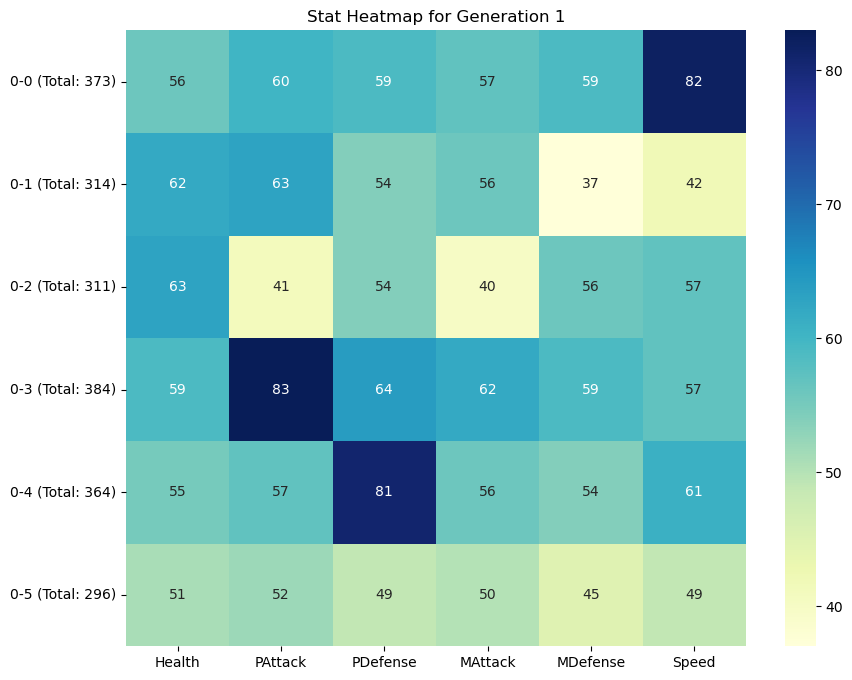

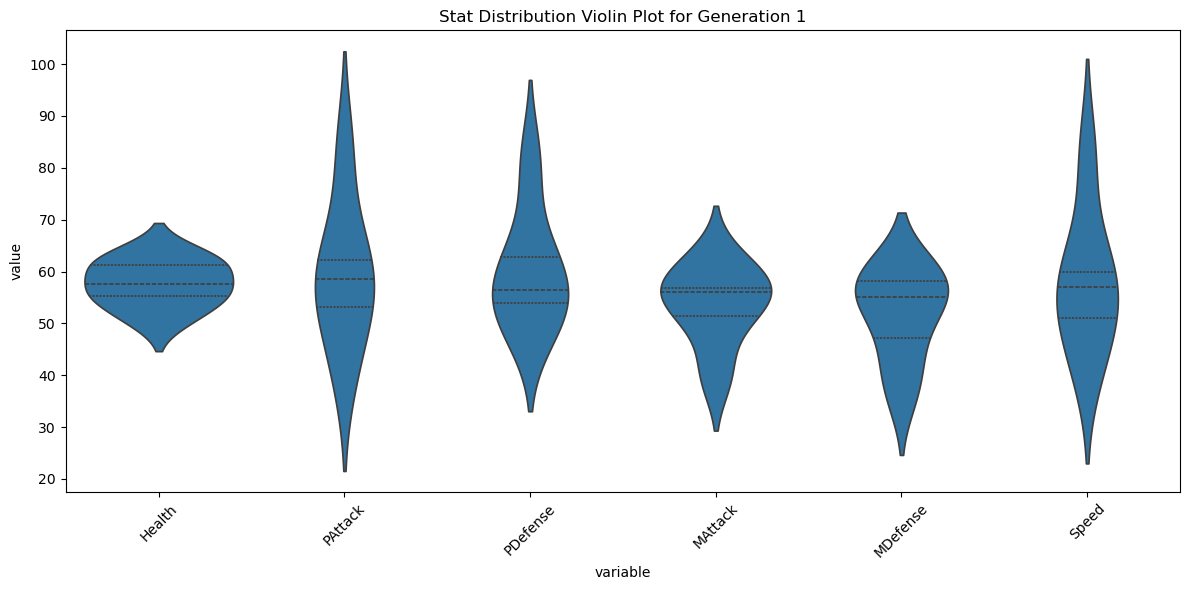

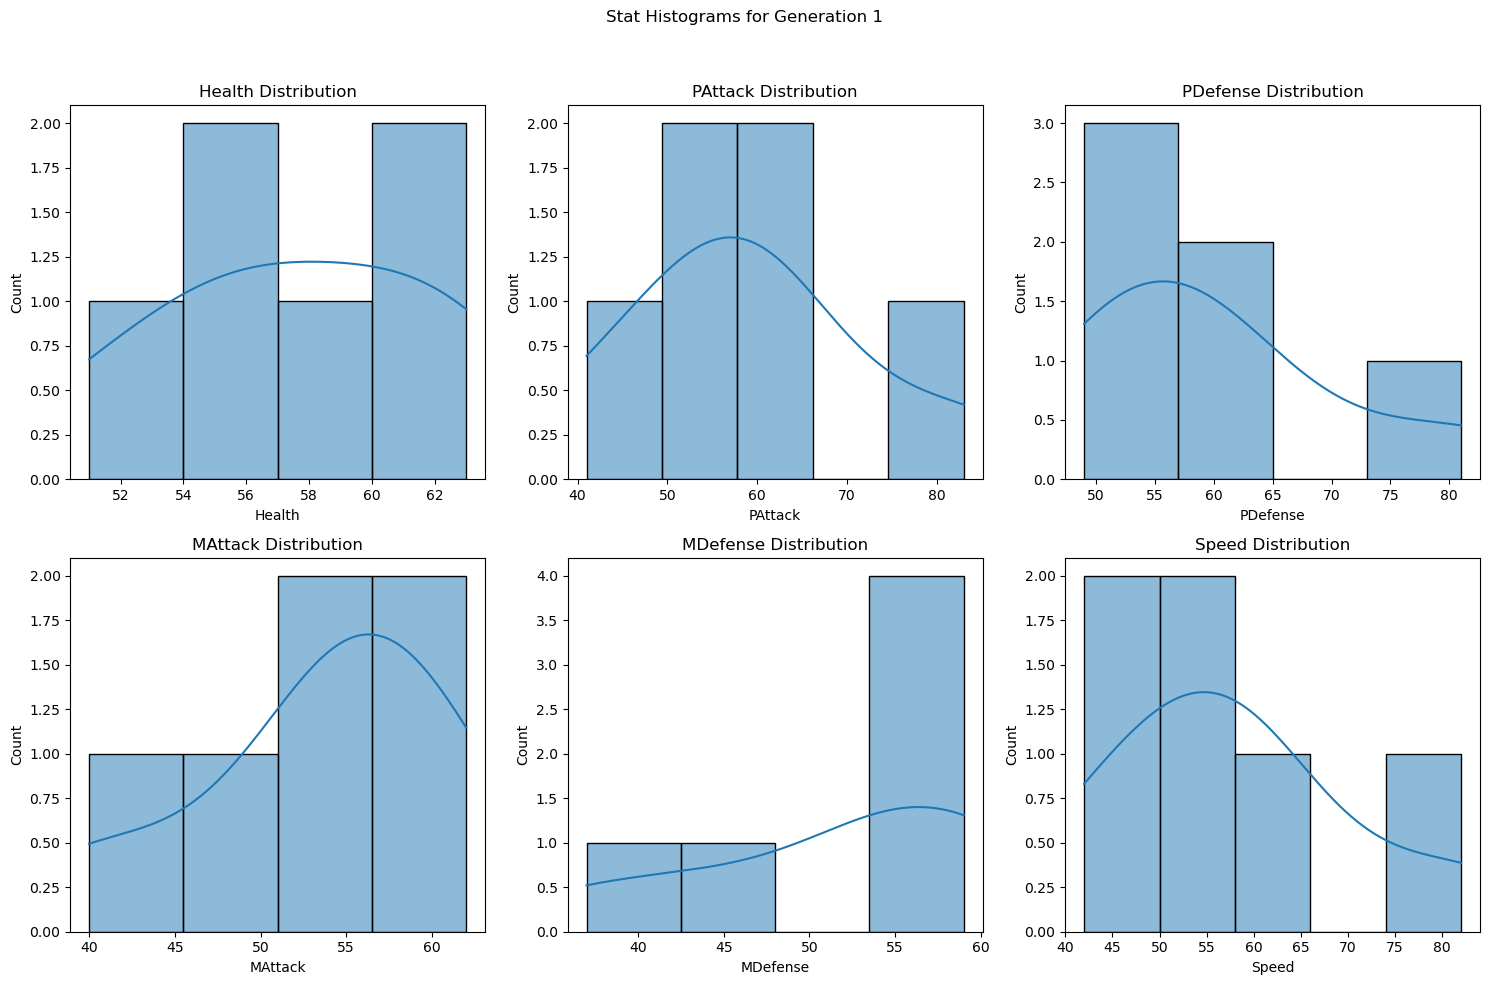

In [142]:
# Running the dashboard for a specific generation
generation = 1  # Set the generation to inspect
generation_data = filter_generation(generation, tree_data)

# Run summary statistics and plot functions with error handling
try:
    summary = summary_statistics(generation_data)
    plot_heatmap(generation_data, generation)
    plot_violin_plots(generation_data, generation)
    plot_distribution_histograms(generation_data, generation)
    plot_radar_chart(generation_data)
    plot_scatter_matrix(generation_data)
except ValueError as e:
    print(f"Data error: {e}")
except KeyError as e:
    print(f"Missing column error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")